In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from p4_copy2 import render_pose_rays
from plenoxel_og_copy2 import render_rays

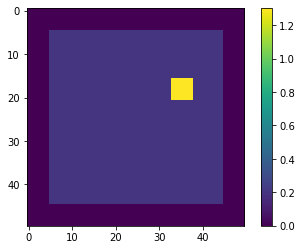

In [36]:
reso = 50

volume = np.zeros((reso, reso, reso))

# Add a large medium-density cube
start = [reso//10, reso//10, reso//10]
extent = [4*reso//5] * 3
volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 0.2

# Add a small high-density cube
start = [reso//3, 2*reso//3, reso//2]
extent = [reso//10] * 3
volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 1.3

# plt.figure()
# plt.imshow(volume[reso//2, :, :])
# plt.colorbar()
# plt.show()
# plt.figure()
# plt.imshow(volume[:, reso//2, :])
# plt.colorbar()
# plt.show()
plt.figure()
plt.imshow(volume[:, :, reso//2])
plt.colorbar()
plt.show()


In [51]:
# Render with the spike projection matrices, using render_pose_rays, and save as a tiff for training
# render_pose_rays(data_dict, c2w, H, W, focal, FLAGS.resolution, radius, FLAGS.harmonic_degree, FLAGS.jitter, FLAGS.uniform, key, sh_dim, FLAGS.physical_batch_size, FLAGS.interpolation, FLAGS.nv)
import jax
import jax.numpy as jnp
import math
import os
from tqdm import tqdm
import tifffile

H = reso * 14
W = reso * 14
dW = 0.024
dH = 0.024
data_dict = [volume]
resolution = reso
radius = 5
xoff =  0.0
yoff =  -1.3 # side to side (lower goes to left)
zoff =  -5.2 # up down (the higher the number the higher the cube goes)

def load_spike_c2w():
    all_w2c = []
    projection_matrices = np.genfromtxt(os.path.join('/home/fabriz/data/spike/', 'proj_mat_720frames.csv'), delimiter=',')  # [719, 12] /home/fabriz/data/spike/proj_mat_720frames.csv

    #Traslation matrix along x,y,z
    Tz = np.zeros((4,4))
    Tz[0,0]=1.0
    Tz[1,1]=1.0
    Tz[2,2]=1.0
    Tz[3,3]=1.0
    Tz[0,3]=-xoff #test
    Tz[1,3]=-yoff #test
    Tz[2,3]=-zoff #test

    for i in range(len(projection_matrices)): 
        # projection matrices P_(3,4)
        w2c = np.reshape(projection_matrices[i], (3,4))
        w2c = np.matmul(w2c,Tz) #applico una traslazione per centrate il volume
        all_w2c.append(w2c)

    return np.asarray(all_w2c)

def get_rays_np(H, W, dH, dW, w2c):
    # get M matrix
    M = w2c[:,0:3]
    # get  p4
    p4 = w2c[:,-1]

    # compute uo,vo,sdd
    uo = (M[0,:]*M[2,:]).sum()
    vo = (M[1,:]*M[2,:]).sum()
    aU = math.sqrt((M[0,:]*M[0,:]).sum() - uo*uo)
    aV = math.sqrt((M[1,:]*M[1,:]).sum() - vo*vo)
    sdd = 0.5*(aU+aV)

    #source position in the World Reference system
    M_inv = np.linalg.inv(M)
    srcPos = -np.matmul(M_inv,p4)
    
    shiftVo = (vo - 0.5 * H * dH)
    u, v = jnp.meshgrid(jnp.linspace(0, W-1, W) + 0.5, jnp.linspace(0, H-1, H) + 0.5)
    u = u * dW # u
    v = v * dH # v
    dirs   = jnp.stack([u, v, jnp.ones_like(u)], -1) 
    rays_d = jnp.sum(dirs[..., jnp.newaxis, :] * M_inv, -1) # check if the syntax is ok
    rays_o = jnp.broadcast_to(srcPos,rays_d.shape)          # check if the syntax is ok
    return rays_o, rays_d

all_c2w = load_spike_c2w()
# for c2w in all_c2w[::50]:
all_rgbs = []
for c2w in tqdm(all_c2w):
    rays_o, rays_d = get_rays_np(H, W, dH, dW, c2w)
    rays_o = np.reshape(rays_o, [-1,3])
    rays_d = np.reshape(rays_d, [-1,3])
    rgb, _, acc, _, _ = jax.lax.stop_gradient(render_rays(data_dict, (rays_o, rays_d), resolution, None, radius, harmonic_degree=-1, jitter=0, uniform=0.5, interpolation='trilinear', nv=False))
    rgb = np.reshape(rgb, (H, W))
    all_rgbs.append(rgb)
    # acc = np.reshape(acc, (H, W, 1))
    # plt.figure()
    # plt.imshow(acc)
    # plt.colorbar()
    # plt.show()
all_rgbs = np.array(all_rgbs)
print(all_rgbs.shape)
                                              

tifffile.imsave(f'synthetic_projections_raw_radius{radius}_reso{reso}_H{H}.tif', all_rgbs)
tifffile.imsave(f'synthetic_volume_reso{reso}.tif', volume)

# TODO: train to fit these projections, using the regular version and the linear version


  0%|          | 0/720 [00:00<?, ?it/s]

100%|██████████| 720/720 [00:15<00:00, 45.62it/s]


(720, 700, 700)


/tmp/ipykernel_273475/530541979.py:88: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(f'synthetic_projections_raw_radius{radius}_reso{reso}_H{H}.tif', all_rgbs)
/tmp/ipykernel_273475/530541979.py:89: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(f'synthetic_volume_reso{reso}.tif', volume)
